# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans

In [3]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

bad_idx = f.index[f.isna().any(axis=1)]
print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
print("rows_with_na first", rows_with_na)

f = f.dropna()

print(f.dtypes)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object
[10413518, 10413697, 10415434, 10415668, 10417031, 10417714, 10417770, 10421216, 10421276, 10422411, 10422596, 10422885, 10422892, 10423047, 10423230, 10423232, 10423388, 10423461, 10423832, 10423867, 10423879, 10423981, 10424026, 10424117, 10424185, 10424278, 10424294, 10424452, 10424591, 10425255, 10425520, 10425626, 10425772, 10426135, 10426607, 10427815, 10427993, 10428027, 10428296, 10428504, 10428784, 10428794, 10430531, 10433528, 10436246, 10438241, 10440685, 10443234, 10444360, 10444

In [4]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548334,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1
17548335,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320.0,40.794067,-73.962868,2006.0,40.765909,-73.976342,16390,Customer,1969,0
17548336,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1
17548337,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320.0,40.794067,-73.962868,281.0,40.764397,-73.973715,30818,Customer,1969,0


1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

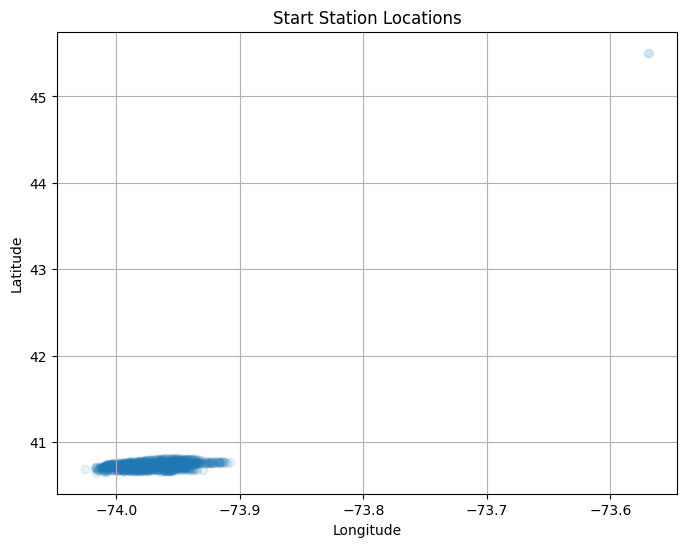

In [5]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [6]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude
676612           3488.0               45.506364               -73.569463
714485           3650.0               45.506264               -73.568906


In [7]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


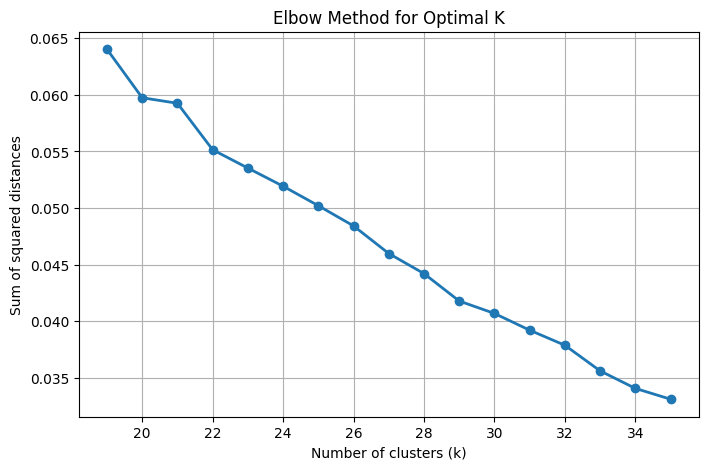

In [8]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

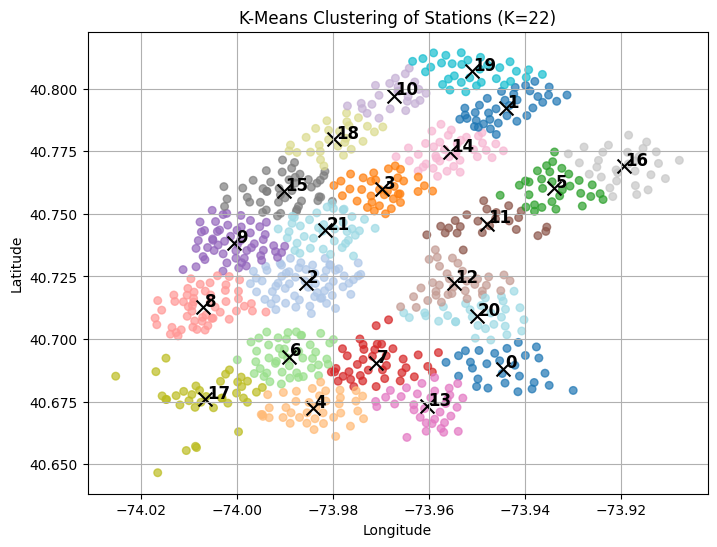

In [9]:
#We observe that k=22 should be a good choice for the number of clusters.

import matplotlib.pyplot as plt

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [20]:
# We want to only look at the clusters that make up the island of Manhattan
# We are only interested in datapoints where either start_station_id or end_station_id is in in one of the clusters

clusters_to_keep = [2,8,9,15,21]

# Normalize dtypes on keys before building merge
f = f.copy()
f['start_station_id'] = f['start_station_id'].astype(str)
f['end_station_id']   = f['end_station_id'].astype(str)

f_cluster = f_cluster.copy()
f_cluster['start_station_id'] = f_cluster['start_station_id'].astype(str)

stations_to_keep = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_keep),
    'start_station_id'
].unique()

f = f[
    f['start_station_id'].isin(stations_to_keep) |
    f['end_station_id'].isin(stations_to_keep)
].copy()


In [21]:
# Add cluster column to original data frame
f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'cluster': 'start_cluster'}),
    on='start_station_id',
    how='left'
)

f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'start_station_id': 'end_station_id', 'cluster': 'end_cluster'}),
    on='end_station_id',
    how='left'
)

for col in ['start_cluster', 'end_cluster']:
    f[col] = pd.to_numeric(f[col], errors='coerce').astype('Int64')

In [12]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,15,21
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,15,15
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,15,15
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,15,15
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14229621,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1,9,15
14229622,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320.0,40.794067,-73.962868,2006.0,40.765909,-73.976342,16390,Customer,1969,0,10,3
14229623,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1,8,8
14229624,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320.0,40.794067,-73.962868,281.0,40.764397,-73.973715,30818,Customer,1969,0,10,3


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

In [13]:
full_idx = pd.date_range(f['starttime'].min().floor('H'),
                         f['starttime'].max().ceil('H'),
                         freq='H')


def hourly_series_from_trips(df, time_col, cluster_col, cluster_id):
    """Return a single hourly Series (DatetimeIndex, freq='h') for one cluster."""
    s = (df.loc[df[cluster_col] == cluster_id, time_col]
           .dt.floor('H')
           .value_counts()
           .sort_index())
    s.index.name = 'timestamp'
    s = s.reindex(full_idx, fill_value=0).astype(int) # keep rows where there are now pickups/dropoffs
    s.name = f'{cluster_col}_{cluster_id}'
    return s

pickup_series  = {c: hourly_series_from_trips(f, 'starttime', 'start_cluster', c)
                  for c in clusters_to_keep}
dropoff_series = {c: hourly_series_from_trips(f, 'stoptime',  'end_cluster',   c)
                  for c in clusters_to_keep}



/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/831590711.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(f['starttime'].min().floor('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/831590711.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f['starttime'].max().ceil('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, p

In [14]:
dropoff_series[9]

2018-01-01 00:00:00    18
2018-01-01 01:00:00    23
2018-01-01 02:00:00    12
2018-01-01 03:00:00    12
2018-01-01 04:00:00     7
                       ..
2018-12-31 20:00:00    17
2018-12-31 21:00:00     8
2018-12-31 22:00:00    14
2018-12-31 23:00:00     7
2019-01-01 00:00:00     2
Freq: h, Name: end_cluster_9, Length: 8761, dtype: int64

In [15]:
# PICKUPS
pick = (f.loc[f['start_cluster'].isin(clusters_to_keep), ['starttime','start_cluster']]
          .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
          .value_counts(['timestamp','start_cluster'])
          .rename('count')
          .reset_index())

# Build all (timestamp, cluster) combos, then left-join and fill 0
full_pairs = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','start_cluster']
    ).to_frame(index=False)
)

pickup_all = (
    full_pairs.merge(pick, on=['timestamp','start_cluster'], how='left')
              .fillna({'count': 0})
              .astype({'count':'int64'})
              .set_index(['timestamp','start_cluster'])
              .sort_index()
)

# DROPOFFS
drop = (f.loc[f['end_cluster'].isin(clusters_to_keep), ['stoptime','end_cluster']]
          .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
          .value_counts(['timestamp','end_cluster'])
          .rename('count')
          .reset_index())

full_pairs_d = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','end_cluster']
    ).to_frame(index=False)
)

dropoff_all = (
    full_pairs_d.merge(drop, on=['timestamp','end_cluster'], how='left')
                .fillna({'count': 0})
                .astype({'count':'int64'})
                .set_index(['timestamp','end_cluster'])
                .sort_index()
)


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/1095759283.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))


In [16]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,15,21
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,15,15
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,15,15
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,15,15
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14229621,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1,9,15
14229622,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320.0,40.794067,-73.962868,2006.0,40.765909,-73.976342,16390,Customer,1969,0,10,3
14229623,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1,8,8
14229624,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320.0,40.794067,-73.962868,281.0,40.764397,-73.973715,30818,Customer,1969,0,10,3


In [22]:
train_end = pd.Timestamp('2018-10-31 23:00:00')
test_start = pd.Timestamp('2018-11-01 00:00:00')

In [100]:
def make_nextday_lag24_dataset(s: pd.Series, horizon: int = 24):
    """
    Build a supervised dataset with only the last 24 hourly lags.
    One row per day at 23:00, targets are the next day's 24 hours.
    """
    s = s.asfreq('H').fillna(0).astype(float)
    df = pd.DataFrame({'y': s})

    for L in range(1, 25):
        df[f'lag_{L:02d}'] = df['y'].shift(L)

    # +1 weekly lag
    df['lag_168'] = df['y'].shift(168)

    df['DOW'] = df.index.dayofweek.astype('int8')
    df['hour'] = df.index.hour.astype('int8')       # 0..23

    for h in range(1, horizon + 1):
        df[f'y_tplus{h:02d}'] = df['y'].shift(-h)

    # keep only end-of-day rows (23:00)
    eod = (df.index.hour == 23)

    X = df.loc[eod, [f'lag_{L:02d}' for L in range(1, 25)] + ['lag_168', 'DOW', 'hour']]
    Y = df.loc[eod, [f'y_tplus{h:02d}' for h in range(1, horizon + 1)]]

    # drop rows with NaNs from edges
    mask = ~(X.isna().any(axis=1) | Y.isna().any(axis=1))
    X, Y = X.loc[mask], Y.loc[mask]

    # split by calendar
    train_mask = X.index <= train_end
    Xtr, Ytr = X.loc[train_mask], Y.loc[train_mask]
    Xte, Yte = X.loc[~train_mask], Y.loc[~train_mask]
    return Xtr, Ytr, Xte, Yte

In [101]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer

In [103]:
def fit_gbr_24lags(s: pd.Series):
    """
    Fit GradientBoosting to predict next-day 24 hours.
    """
    Xtr, Ytr, Xte, Yte = make_nextday_lag24_dataset(s)

    num_cols = [c for c in Xtr.columns if c.startswith('lag_')]
    cat_cols = ['DOW', 'hour']

    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])

    base = GradientBoostingRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=2,
        subsample=0.7, random_state=42, loss='huber'
    )

    model = Pipeline([('pre', pre), ('est', MultiOutputRegressor(base))])
    model.fit(Xtr, Ytr)
    
    Yhat = model.predict(Xte)  # shape: [n_test_days, 24]

    # metrics
    rmse_per_h = np.sqrt(((Yhat - Yte.values) ** 2).mean(axis=0))
    scores = {
        'MAE_mean': mean_absolute_error(Yte.values.flatten(), Yhat.flatten()),
        'RMSE_mean': rmse_per_h.mean(),
        'RMSE_per_hour': rmse_per_h,
        'n_test_days': len(Xte)
    }
    return model, (Xtr, Ytr, Xte, Yte, Yhat, scores)

In [94]:
models_pick, eval_pick = {}, {}
models_drop, eval_drop = {}, {}

for c in clusters_to_keep:
    # Pickups
    m_p, (Xtr_p, Ytr_p, Xte_p, Yte_p, Yhat_p, sc_p) = fit_gbr_24lags(pickup_series[c])
    models_pick[c] = m_p
    eval_pick[c]   = {'Xtr': Xtr_p, 'Ytr': Ytr_p, 'Xte': Xte_p, 'Yte': Yte_p, 'Yhat': Yhat_p, 'scores': sc_p}

    # Dropoffs
    m_d, (Xtr_d, Ytr_d, Xte_d, Yte_d, Yhat_d, sc_d) = fit_gbr_24lags(dropoff_series[c])
    models_drop[c] = m_d
    eval_drop[c]   = {'Xtr': Xtr_d, 'Ytr': Ytr_d, 'Xte': Xte_d, 'Yte': Yte_d, 'Yhat': Yhat_d, 'scores': sc_d}


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/4276113593.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/4276113593.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/4276113593.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/4276113593.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/4276113593.py:6: FutureWarning: 'H' is 

In [78]:
eval_pick[15]['scores'], eval_drop[15]['scores']

({'MAE_mean': 54.927088520440186,
  'RMSE_mean': np.float64(72.8849112772153),
  'RMSE_per_hour': array([ 12.5921175 ,   8.29046491,   6.11594344,   4.17747618,
           5.97125792,  21.4435054 ,  75.96525773,  92.8729708 ,
         174.42316754, 122.14658236,  62.8168936 ,  60.92793817,
          60.85839484,  65.40873401,  71.10134319,  92.27795308,
         122.45206991, 199.60087226, 190.68353105, 118.27846146,
          68.0606777 ,  48.60316516,  38.71578937,  25.45330308]),
  'n_test_days': 60},
 {'MAE_mean': 56.07918804787447,
  'RMSE_mean': np.float64(75.72724527855887),
  'RMSE_per_hour': array([ 10.87687753,   8.00550966,   5.47303024,   4.01772398,
           4.99845511,  10.64246875,  43.67007685,  88.57976449,
         160.78883713, 135.49807453,  63.20177383,  61.06249803,
          65.61511656,  78.86745892,  86.84522887, 112.87629808,
         153.95785474, 236.17356763, 198.46900555, 119.53509781,
          65.75096306,  44.65983585,  33.57023386,  24.3181356 ]),
  

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rebuild_hourly_from_nextday(eval_entry: dict, base_series: pd.Series) -> tuple[pd.Series, pd.Series]:
    """
    Take one eval_*[cluster] entry and the original hourly base_series (pickups or dropoffs),
    and return two aligned hourly Series: y_true_hourly, y_pred_hourly over the Nov–Dec test span.
    """
    # Each row in Xte index is the *origin* at 23:00 of day D (end-of-day).
    # The prediction Yhat[i] is for the next day: hours D+1 00:00..23:00.
    origins = pd.DatetimeIndex(eval_entry['Xte'].index)  # 23:00 timestamps
    yhat    = np.asarray(eval_entry['Yhat'])             # shape [n_days, 24]
    yte     = np.asarray(eval_entry['Yte'].values)       # shape [n_days, 24]

    pred_idx_all = []
    pred_vals_all = []
    true_vals_all = []

    for i, origin in enumerate(origins):
        day_start = (origin + pd.Timedelta(hours=1)).floor('D')  # next day 00:00
        idx_24 = pd.date_range(day_start, periods=24, freq='H')

        pred_idx_all.append(idx_24)
        pred_vals_all.append(yhat[i])
        true_vals_all.append(yte[i])

    pred_idx_all = pd.DatetimeIndex(np.concatenate(pred_idx_all))
    y_pred_hourly = pd.Series(np.concatenate(pred_vals_all), index=pred_idx_all, name='yhat')
    y_true_hourly = pd.Series(np.concatenate(true_vals_all), index=pred_idx_all, name='ytrue')

    # (Optional) sanity align with the original hourly series (keeps only test hours)
    start, end = pred_idx_all.min(), pred_idx_all.max()
    base_slice = base_series.asfreq('H').loc[start:end].astype(float)
    # Ensure same index:
    y_true_hourly = base_slice.reindex(y_true_hourly.index, fill_value=0)  # replace with base truth if you prefer

    return y_true_hourly, y_pred_hourly


In [96]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

def eval_train_test_with_teacher_fn(model, eval_entry, title_prefix=""):
    """
    model: your fitted pipeline (e.g., models_pick[c])
    eval_entry: e.g., eval_pick[c] with keys Xtr,Ytr,Xte,Yte,Yhat
    Prints train and test stats using your teacher's print_stats on flattened arrays.
    Returns a dict with the 6 metrics to optionally show on plots.
    """
    # train
    Ytr_true = eval_entry['Ytr'].values
    Ytr_pred = model.predict(eval_entry['Xtr'])
    print_stats(Ytr_true.flatten(), Ytr_pred.flatten(), title=f"{title_prefix} TRAIN")

    # test
    Yte_true = eval_entry['Yte'].values
    Yte_pred = eval_entry['Yhat']
    print_stats(Yte_true.flatten(), Yte_pred.flatten(), title=f"{title_prefix} TEST")

    return {
        'train': {
            'R2':  r2_score(Ytr_true.flatten(), Ytr_pred.flatten()),
            'MAE': mean_absolute_error(Ytr_true.flatten(), Ytr_pred.flatten()),
            'MAPE': mean_absolute_percentage_error(Ytr_true.flatten(), Ytr_pred.flatten())
        },
        'test': {
            'R2':  r2_score(Yte_true.flatten(), Yte_pred.flatten()),
            'MAE': mean_absolute_error(Yte_true.flatten(), Yte_pred.flatten()),
            'MAPE': mean_absolute_percentage_error(Yte_true.flatten(), Yte_pred.flatten())
        }
    }


In [97]:
# Code from week 7 blabla
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()

In [98]:

eval_pick[2]['scores'], eval_drop[2]['scores']


({'MAE_mean': 58.259527293618746,
  'RMSE_mean': np.float64(79.01507094030377),
  'RMSE_per_hour': array([ 18.06883696,  14.01137922,  10.71501344,   6.98392893,
           5.04558453,  11.60121617,  43.13755534,  93.31765937,
         192.52928049, 103.86750795,  77.28284005,  80.53482557,
          81.33421562,  90.83420583,  93.67775281, 107.19826459,
         122.95096728, 160.46350734, 180.40925286, 149.80788253,
         101.04616548,  69.42868212,  47.15946051,  34.9557176 ]),
  'n_test_days': 60},
 {'MAE_mean': 62.11587115510093,
  'RMSE_mean': np.float64(82.333934453812),
  'RMSE_per_hour': array([ 18.78087329,  11.84364974,   9.46526708,   6.76093341,
           5.14059827,   6.99844244,  26.90026008,  53.6217657 ,
          92.89627414,  73.67214074,  62.11079817,  74.84522248,
          76.23559411,  93.53081658,  98.05595322, 116.3861085 ,
         143.88816907, 211.35269263, 258.2005956 , 203.5205715 ,
         140.02508923,  86.51549063,  63.88873273,  41.37838755]),
  '

Pickups cluster 2 TRAIN: 
	r^2=0.989757
	MAE=9.797773
	MAPE=inf
Pickups cluster 2 TEST: 
	r^2=0.705757
	MAE=58.259527
	MAPE=61.680808
Dropoff cluster 2 TRAIN: 
	r^2=0.990166
	MAE=10.272769
	MAPE=inf
Dropoff cluster 2 TEST: 
	r^2=0.632476
	MAE=62.115871
	MAPE=57.688179


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3243000186.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_24 = pd.date_range(day_start, periods

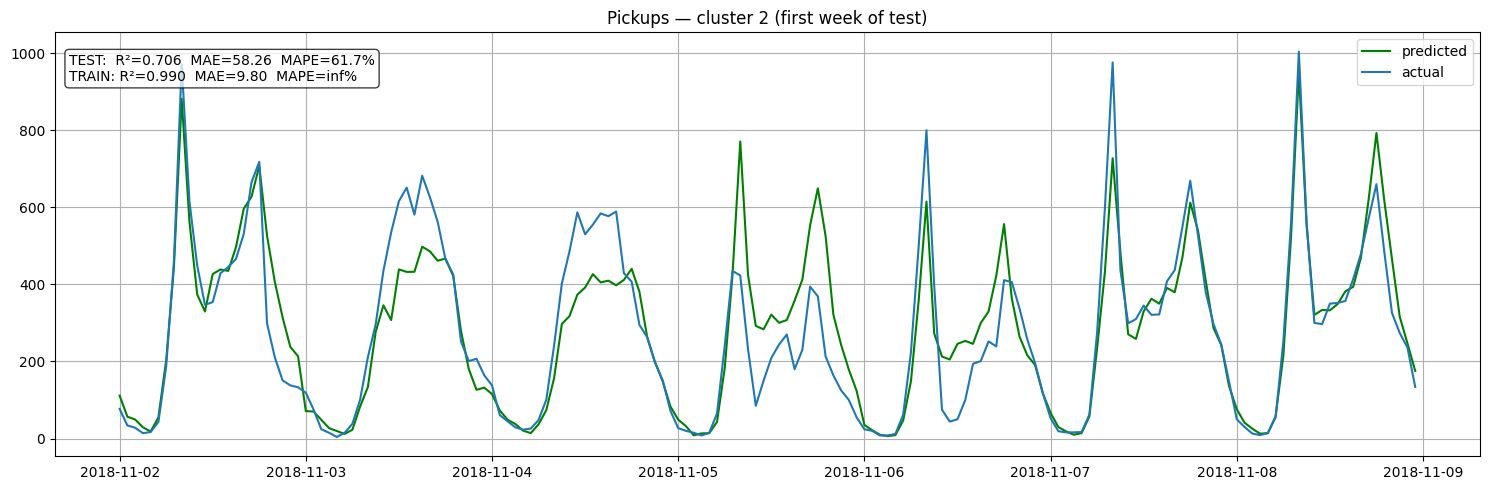

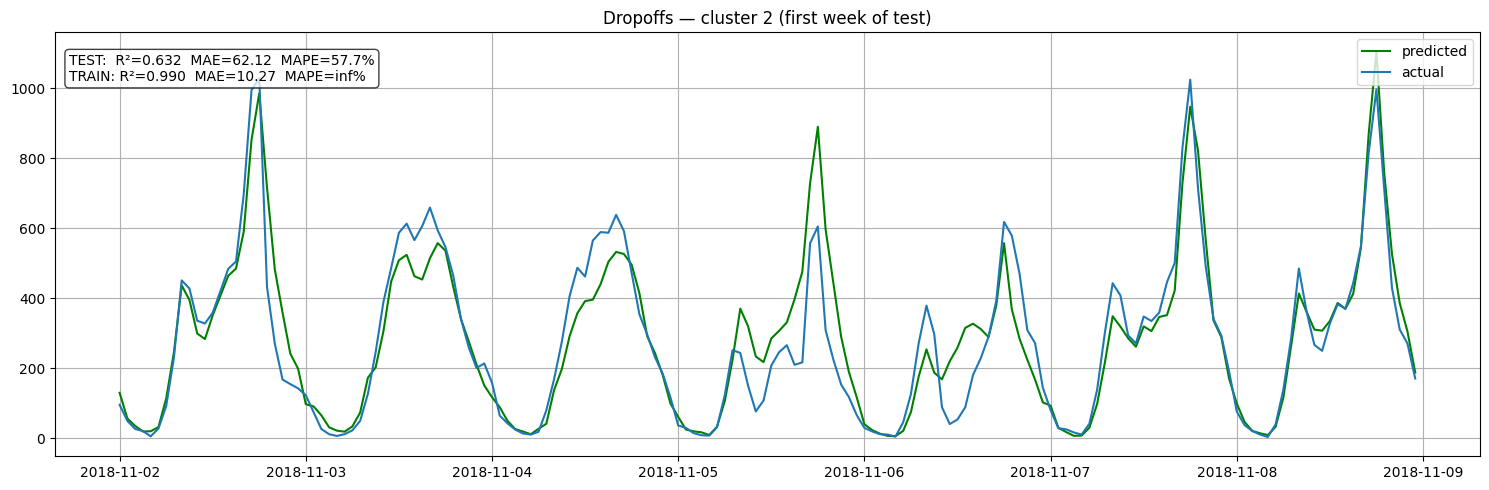

Pickups cluster 8 TRAIN: 
	r^2=0.989246
	MAE=10.088745
	MAPE=inf
Pickups cluster 8 TEST: 
	r^2=0.479336
	MAE=56.355551
	MAPE=inf
Dropoff cluster 8 TRAIN: 
	r^2=0.988087
	MAE=9.760210
	MAPE=inf
Dropoff cluster 8 TEST: 
	r^2=0.672294
	MAE=50.331408
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

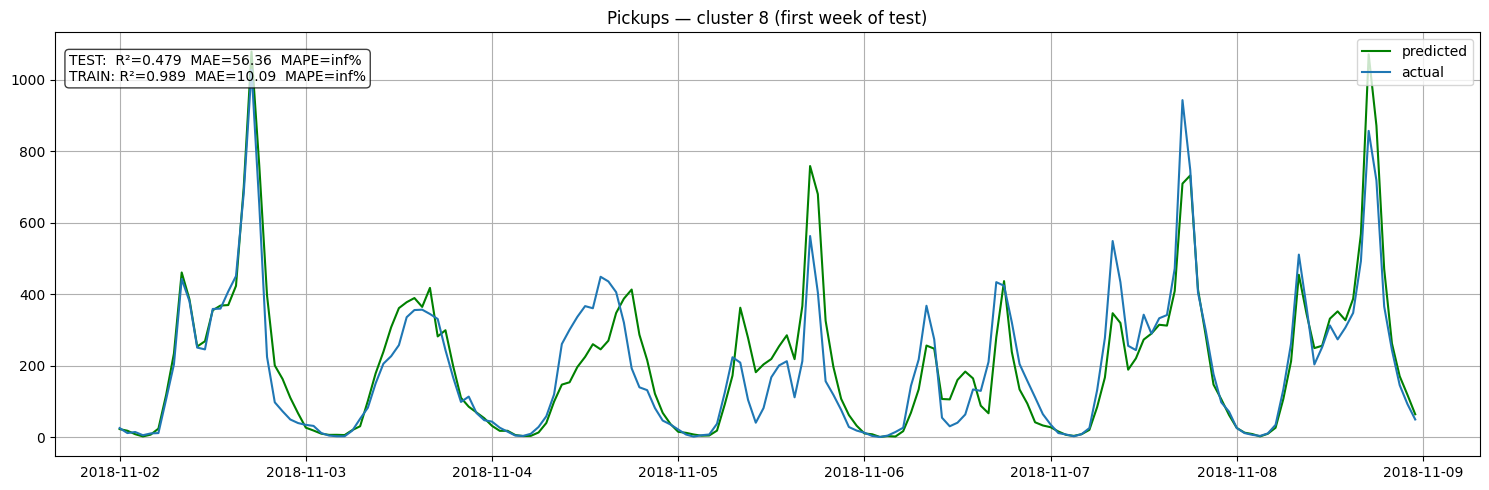

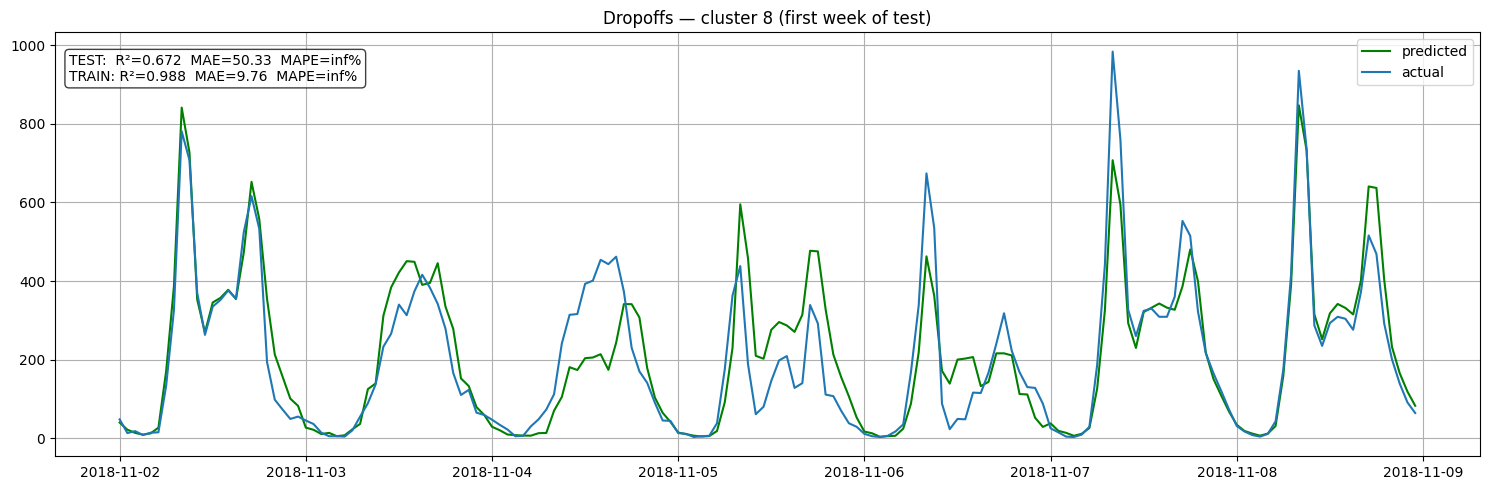

Pickups cluster 9 TRAIN: 
	r^2=0.988527
	MAE=12.729451
	MAPE=inf
Pickups cluster 9 TEST: 
	r^2=0.653171
	MAE=72.146991
	MAPE=75.114168
Dropoff cluster 9 TRAIN: 
	r^2=0.988387
	MAE=13.272994
	MAPE=inf
Dropoff cluster 9 TEST: 
	r^2=0.656474
	MAE=75.696011
	MAPE=75.888669


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3243000186.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_24 = pd.date_range(day_start, periods

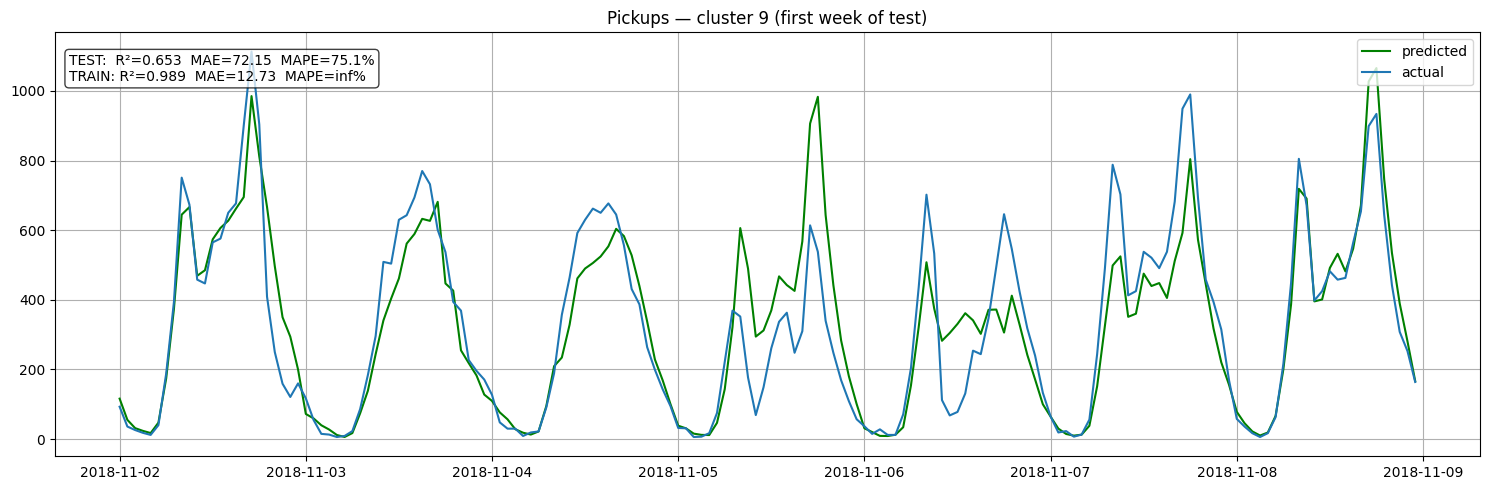

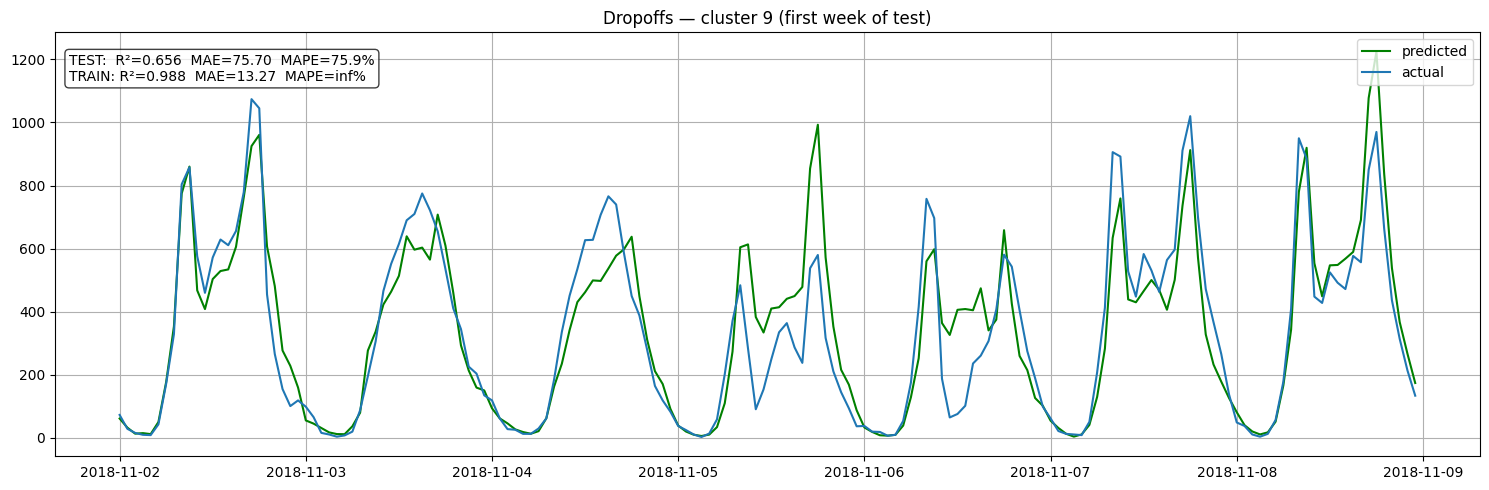

Pickups cluster 15 TRAIN: 
	r^2=0.987898
	MAE=9.733021
	MAPE=inf
Pickups cluster 15 TEST: 
	r^2=0.674890
	MAE=54.927089
	MAPE=inf
Dropoff cluster 15 TRAIN: 
	r^2=0.989457
	MAE=9.603253
	MAPE=inf
Dropoff cluster 15 TEST: 
	r^2=0.655513
	MAE=56.079188
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

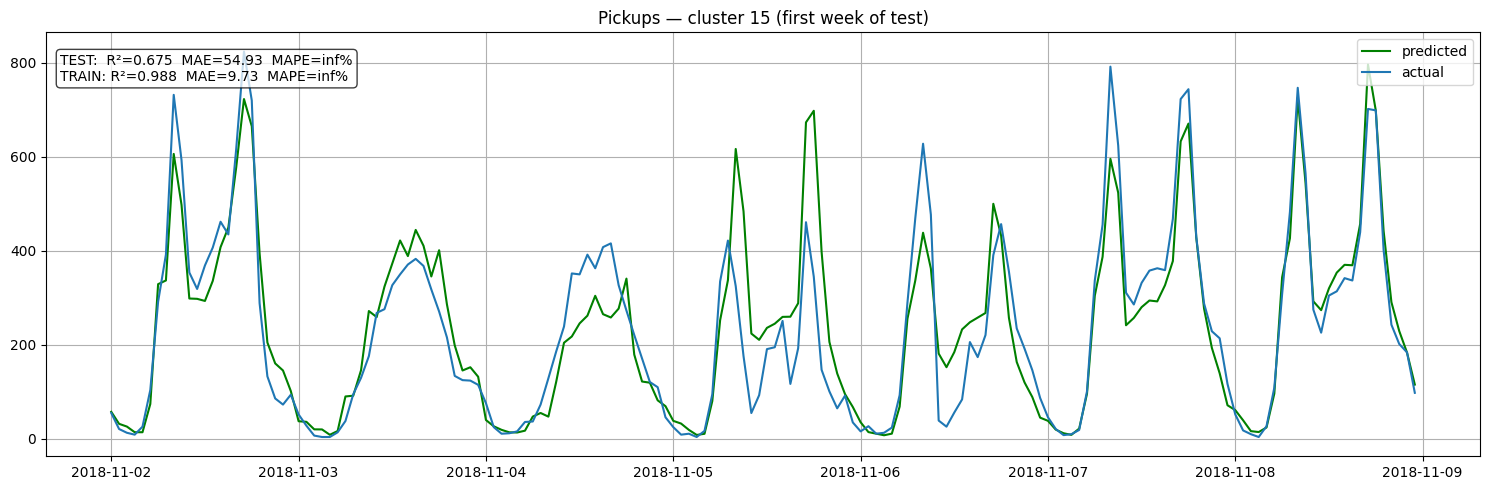

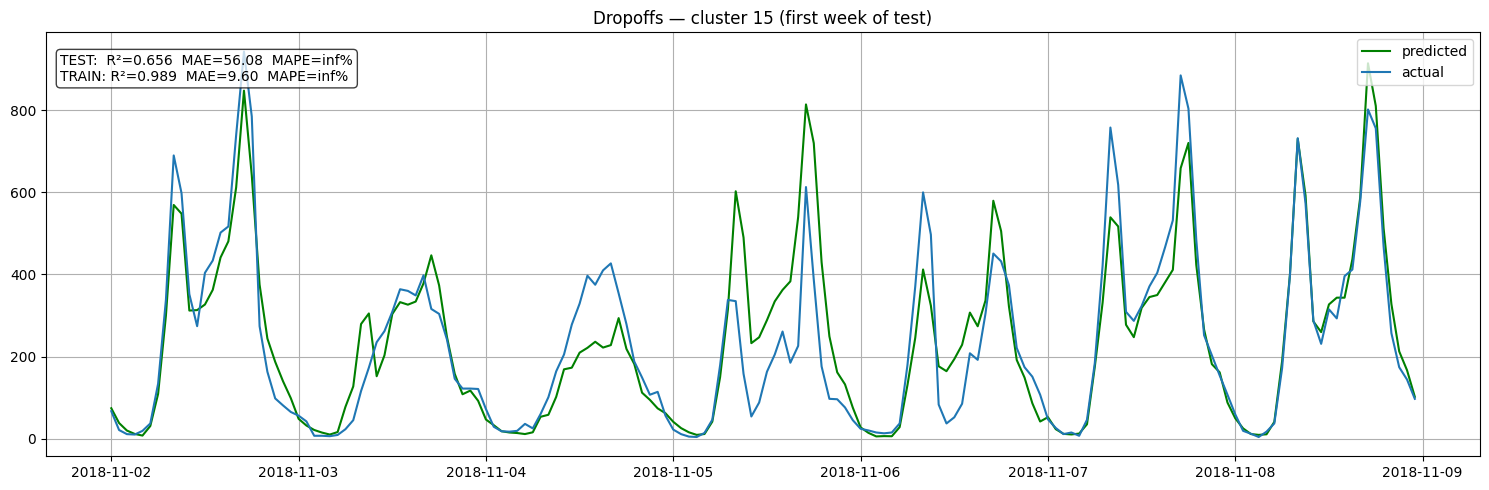

Pickups cluster 21 TRAIN: 
	r^2=0.988750
	MAE=10.002471
	MAPE=inf
Pickups cluster 21 TEST: 
	r^2=0.674953
	MAE=58.001565
	MAPE=77.120327
Dropoff cluster 21 TRAIN: 
	r^2=0.986431
	MAE=9.369575
	MAPE=inf
Dropoff cluster 21 TEST: 
	r^2=0.696268
	MAE=58.141299
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_36046/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

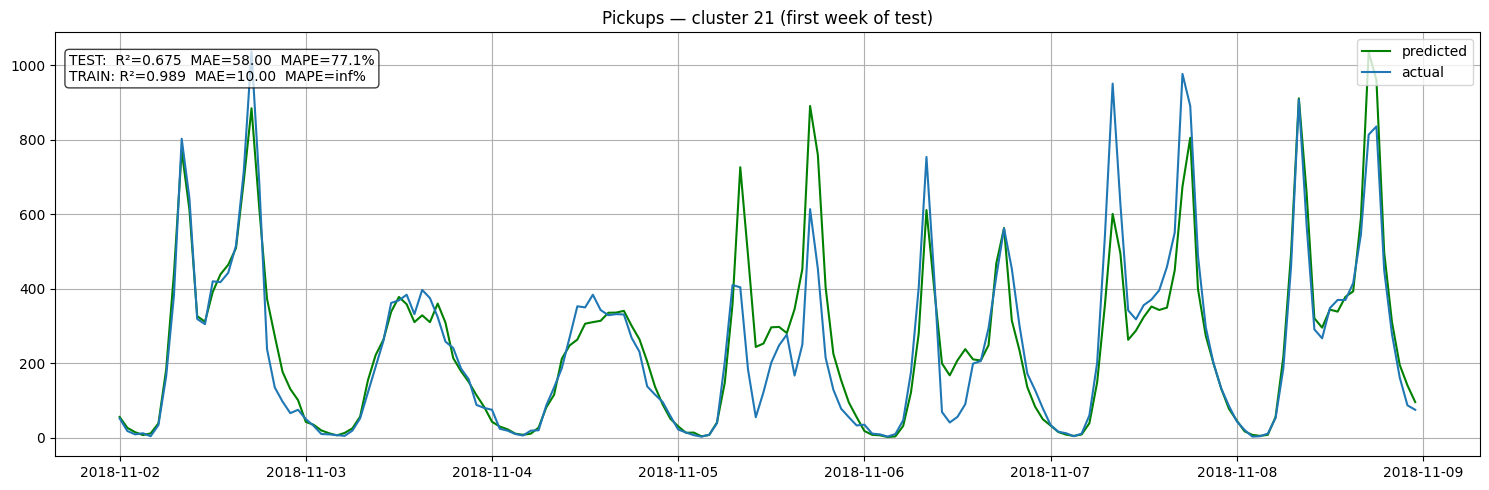

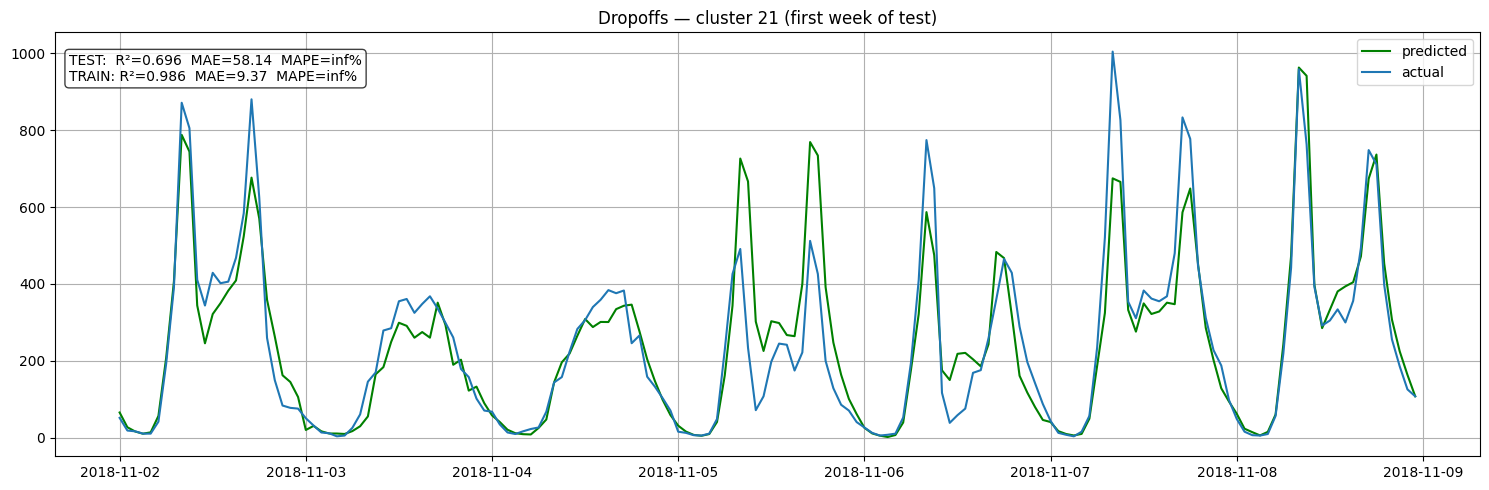

In [99]:
eval_pick[15]['scores'], eval_drop[15]['scores']

# Pick a 168h window starting at the first predicted hour in test
for c in clusters_to_keep:
    if c not in eval_pick or c not in eval_drop:
        print(f"Skipping cluster {c}: missing eval data.")
        continue
    metrics_p = eval_train_test_with_teacher_fn(models_pick[c], eval_pick[c], title_prefix=f"Pickups cluster {c}")
    metrics_d = eval_train_test_with_teacher_fn(models_drop[c], eval_drop[c], title_prefix=f"Dropoff cluster {c}")
    # Rebuild hourly actual vs predicted
    y_true_p, y_pred_p = rebuild_hourly_from_nextday(eval_pick[c], pickup_series[c])
    y_true_d, y_pred_d = rebuild_hourly_from_nextday(eval_drop[c],  dropoff_series[c])

    # First 168 hours (one week) in the test span
    idx_p = y_true_p.index[:168]
    txt_p = [
        f"TEST:  R²={metrics_p['test']['R2']:.3f}  MAE={metrics_p['test']['MAE']:.2f}  MAPE={metrics_p['test']['MAPE']:.1f}%",
        f"TRAIN: R²={metrics_p['train']['R2']:.3f}  MAE={metrics_p['train']['MAE']:.2f}  MAPE={metrics_p['train']['MAPE']:.1f}%"
    ]
    plotprediction(series=y_true_p.loc[idx_p],
                   pred_series=y_pred_p.loc[idx_p],
                   metrics=txt_p,
                   labels=["actual", "predicted"],
                   title=f"Pickups — cluster {c} (first week of test)")

    idx_d = y_true_d.index[:168]
    txt_d = [
        f"TEST:  R²={metrics_d['test']['R2']:.3f}  MAE={metrics_d['test']['MAE']:.2f}  MAPE={metrics_d['test']['MAPE']:.1f}%",
        f"TRAIN: R²={metrics_d['train']['R2']:.3f}  MAE={metrics_d['train']['MAE']:.2f}  MAPE={metrics_d['train']['MAPE']:.1f}%"
    ]
    plotprediction(series=y_true_d.loc[idx_d],
                   pred_series=y_pred_d.loc[idx_d],
                   metrics=txt_d,
                   labels=["actual", "predicted"],
                   title=f"Dropoffs — cluster {c} (first week of test)")


In [ ]:
# Error

3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.